In [1]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
from collections import defaultdict
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
%config InlineBackend.figure_format = 'retina'

In [2]:
pr = Project('FEH')

In [5]:
class Data:
    def __init__(self):
        pass
data = Data()
data.input = Data()
data.output = Data()

In [6]:
data.input.potential = '2007--Lee-B-J--Fe-H--LAMMPS--ipr1'
data.input.temperature = np.arange(500, 1501, 100)
data.input.n_hydrogen = np.arange(0, 2001, 500)

# Quasi Harmonic Approximation

In [8]:
basis = pr.create_ase_bulk('Fe', cubic=True)
lmp = pr.create_job('Lammps', 'lattice_parameter')
lmp.structure = basis
lmp.potential = data.input.potential
# lmp.structure += pr.create_atoms(elements=['H'], positions=[[0, 0, 0.5]])
lmp.calc_minimize(pressure=0)
lmp.run()

2021-01-19 08:55:56,376 - pyiron_log - WARNING - The job lattice_parameter is being loaded instead of running. To re-run use the argument 'delete_existing_job=True in create_job'


In [9]:
data.input.a_0 = pr.load('lattice_parameter').output.cells[-1, 0, 0]

In [ ]:
lmp_murn = pr.create_job('Lammps', 'lmp_murn')
lmp_murn.structure = pr.create_structure('Fe', 'bcc', a_0)
lmp_murn.potential = potential
lmp_murn.interactive_open()

In [ ]:
murn = lmp_murn.create_job('Murnaghan', 'murn')
murn.run()

In [ ]:
lmp_phono = pr.create_job('Lammps', 'lmp_phono')
lmp_phono.structure = pr.create_structure('Fe', 'bcc', a_0)
lmp_phono.potential = potential

phono = lmp_phono.create_job('PhonopyJob', 'phono')
qha = phono.create_job('QuasiHarmonicJob', 'qha')
qha.input['temperature_end'] = 1500
qha.input['temperature_steps'] = 100
qha.run()

In [ ]:
results = qha.optimise_volume(bulk_eng=murn['output/energy'])
temperatures = qha['output/temperatures'][0]
plt.plot(temperatures, np.asarray(results[0])**(1/3));

In [10]:
from scipy.interpolate import interp1d
qha = pr.load('qha')
murn = pr.load('murn')
results = qha.optimise_volume(bulk_eng=murn['output/energy'])
temperatures = qha['output/temperatures'][0]
def get_lattice_constant(temperature, a_lst=np.asarray(results[0])**(1/3), t_lst=temperatures):
    f = interp1d(t_lst, a_lst)
    return f(temperature)*1
data.get_lattice_constant = get_lattice_constant

# Vacancy formation energy

In [16]:
def get_relaxed_structure(structure, potential=data.input.potential):
    job = pr.create_job('Lammps', 'lmp_relax', True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run()
    return job.get_structure()

data.input.n_repeat = 4

In [ ]:
for name in ['bulk', 'vacancy']:
    for T in temperature_range:
        job_name = 'lmp_{}_{}'.format(name, T)
        lmp = pr.create_job('Lammps', job_name)
        lmp.potential = potential
        structure = pr.create_structure('Fe', 'bcc', get_lattice_constant(T)).repeat(n_repeat)
        if name == 'vacancy':
            del structure[0]
        lmp.structure = get_relaxed_structure(structure)
        lmp.interactive_open()
        phono = lmp.create_job('PhonopyJob', job_name.replace('lmp', 'phono'))
        phono.run()

In [ ]:
for name in ['bulk', 'vacancy']:
    job_name = 'lmp_{}'.format(name)
    lmp = pr.create_job('Lammps', job_name)
    lmp.potential = potential
    lmp.calc_minimize()
    lmp.interactive_open()
    for T in temperature_range:
        structure = pr.create_structure('Fe', 'bcc', get_lattice_constant(T)).repeat(n_repeat)
        if name == 'vacancy':
            del structure[0]
        lmp.structure = structure
        lmp.run()
    lmp.interactive_close()

In [12]:
vac_dict = defaultdict(list)
for name in ['bulk', 'vacancy']:
    for T in data.input.temperature:
        job_name = 'phono_{}_{}'.format(name, T)
        phono = pr.load(job_name)
        vac_dict[name].extend(phono.get_thermal_properties(temperatures=T).free_energies)

for name in vac_dict.keys():
    vac_dict[name] = pr.inspect('lmp_{}'.format(name))['output/generic/energy_pot']+np.asarray(vac_dict[name])

In [18]:
data.output.v_energy = vac_dict['vacancy']-np.asarray(vac_dict['bulk'])*(data.input.n_repeat**3-0.5)/data.input.n_repeat**3

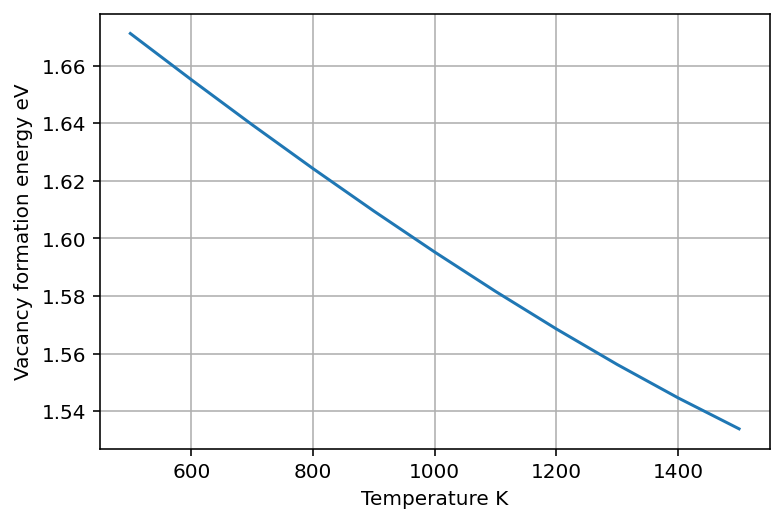

In [21]:
plt.xlabel('Temperature K')
plt.ylabel('Vacancy formation energy eV')
plt.grid()
plt.plot(data.input.temperature, data.output.v_energy);

# Create slab

In [24]:
def get_initial_structure(temperature=0, n_repeat=40, pr=pr, number_of_hydrogen=0, vacuum_length=50):
    a_0 = get_lattice_constant(temperature)
    structure = pr.create_structure('Fe', 'bcc', a_0).repeat(n_repeat)
#     del structure[0]
    if number_of_hydrogen>0:
        positions = structure.positions+np.array([0.5*a_0, 0, 0])
        positions = np.random.permutation(positions)
        structure += pr.create_atoms(
            elements=number_of_hydrogen*['H'],
            positions=positions[:number_of_hydrogen],
            cell=structure.cell
        )
    structure.cell[2,2] += vacuum_length
    structure.positions[:,2] += 0.5*vacuum_length
    return structure

In [80]:
data.get_initial_structure = get_initial_structure

In [ ]:
for temperature in data.input.temperature:
    for n_hydrogen in n_hydrogen_range:
        lmp = pr.create_job('Lammps', 'lmp_{}_{}'.format(n_hydrogen, temperature))
        lmp.structure = get_initial_structure(temperature=temperature, number_of_hydrogen=n_hydrogen)
        lmp.potential = data.input.potential
        lmp.calc_md(temperature=temperature, n_ionic_steps=1e6, n_print=1e4, time_step=0.5)
        lmp.server.cores = 20
        lmp.server.queue = 'cm'
        lmp.run()

In [ ]:
for temperature in temperature_range:
    for n_hydrogen in n_hydrogen_range:
        job = pr.load('lmp_{}_{}'.format(n_hydrogen, temperature))
        structure = job.get_structure()
        structure = structure[structure.select_index('Fe')]
        lmp_minim = pr.create_job(
            'Lammps',
            '{}_{}'.format(job.job_name.replace('lmp', 'minim'), len(job['output/generic/energy_pot']))
        )
        if not lmp_minim.status.initialized:
            continue
        lmp_minim.structure = structure
        lmp_minim.potential = job.potential
        lmp_minim.calc_minimize()
        lmp_minim.server.queue = 'cm'
        lmp_minim.server.run_time = 3600
        lmp_minim.run()

# Evaluate

In [81]:
data.get_initial_structure(n_repeat=10).plot3d()

NGLWidget()

In [ ]:
vac_dict = {}
v_concentration = {}
jt = pr.job_table()
for temperature in data.input.temperature:
    for n_hydrogen in data.input.n_hydrogen:
        job_name = 'minim_{}_{}'.format(n_hydrogen, temperature)
        job_lst = list(jt[jt.job.str.startswith(job_name)].job)
        if len(job_lst)==0:
            continue
        job_name = job_lst[0]
        job = pr.load(job_name)
        structure = job.get_structure()
        cna = job['user/cna']
        if cna is None:
            cna = structure.analyse.pyscal_cna_adaptive(mode='str')
            job['user/cna'] = cna.tolist()
        cna = np.array(cna)
        buffer = 20
        x, indices = structure.get_extended_positions(buffer, return_indices=True)
        x_amorph = x[cna[indices]!='bcc']
        cluster = AgglomerativeClustering(
            distance_threshold=get_lattice_constant(temperature=temperature),
            n_clusters=None,
            linkage='single'
        )
        result = cluster.fit(x_amorph)
        unique, counts = np.unique(result.labels_, return_counts=True)
        x_mean = np.array([np.mean(x_amorph[result.labels_==ii], axis=0) for ii in unique])
        in_box = np.all(x_mean[:,:2]>0, axis=-1) & np.all(x_mean[:,:2]-structure.cell.diagonal()[:2]<0, axis=-1)
        counts = counts[in_box]
#         n_v = np.sum(np.all(x_mean[:,:2]>0, axis=-1) & np.all(x_mean[:,:2]-structure.cell.diagonal()[:2]<0, axis=-1))
        vac_dict[job_name] = len(counts)+np.sum(counts>15)-4
        r = np.prod(structure.cell.diagonal()[:2]+2*buffer)/np.prod(structure.cell.diagonal()[:2])
        v_concentration[job_name] = vac_dict[job_name]/(len(structure)-np.sum(counts[-2:]))

In [76]:
job_name = 'minim_2000_1500_101'
job = pr.load(job_name)
structure = job.get_structure()

cna = np.asarray(job['user/cna'])

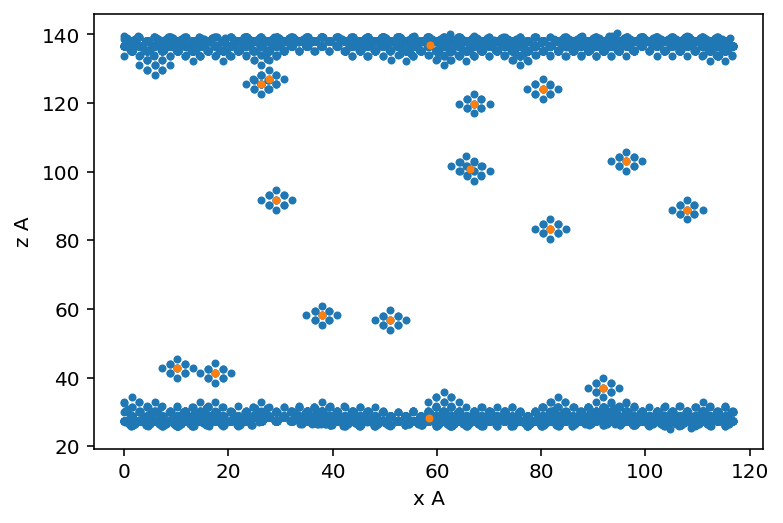

In [91]:
x = structure.positions[cna!='bcc']
plt.xlabel('x A')
plt.ylabel('z A')
plt.scatter(x[:,0], x[:,2], marker='.');
plt.scatter(x_mean[in_box,0], x_mean[in_box,2], marker='.');

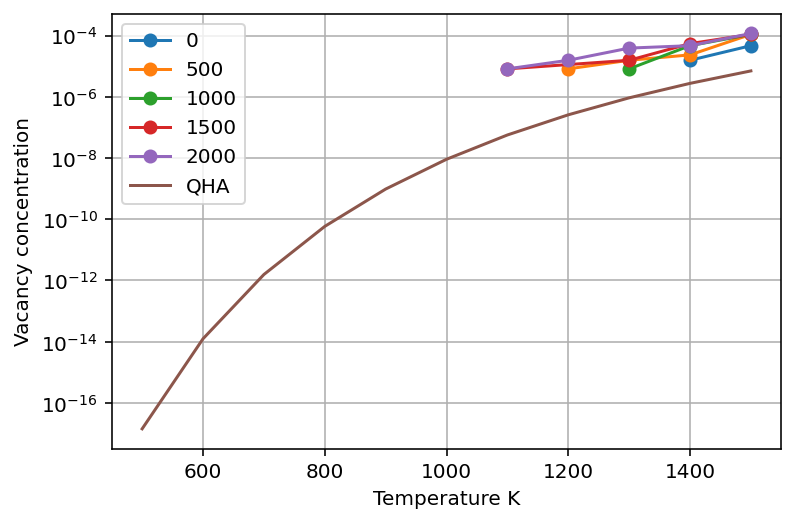

In [101]:
plt.xlabel('Temperature K')
plt.ylabel('Vacancy concentration')
plt.grid()
plt.yscale('log')

for n in data.input.n_hydrogen:
    v = np.asarray([v_concentration['minim_{}_{}_101'.format(n, t)] for t in data.input.temperature])
    plt.plot(data.input.temperature[v>0], v[v>0], '-o', label=str(n))
plt.plot(data.input.temperature, np.exp(-data.output.v_energy/(8.617e-5*data.input.temperature)), label='QHA');
plt.legend();

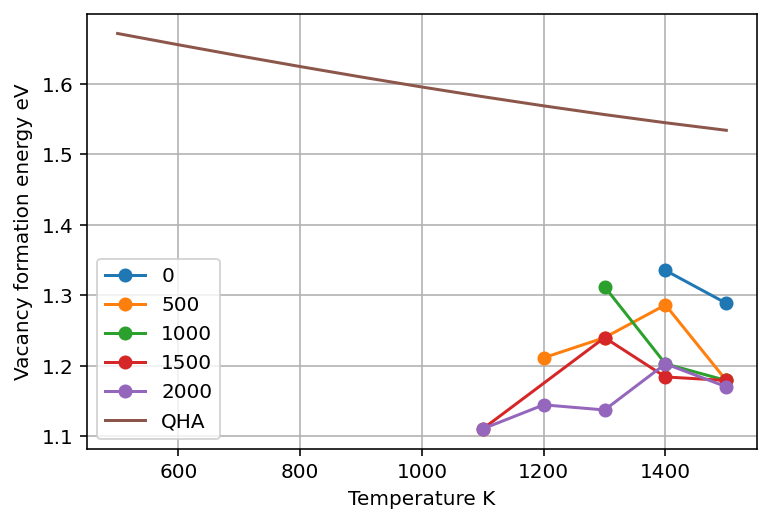

In [98]:
plt.xlabel('Temperature K')
plt.ylabel('Vacancy formation energy eV')
plt.grid()

for n in data.input.n_hydrogen:
    v = np.asarray([v_concentration['minim_{}_{}_101'.format(n, t)] for t in data.input.temperature])
    plt.plot(data.input.temperature[v>0], -np.log(v[v>0])*8.617e-5*data.input.temperature[v>0], '-o', label=str(n))
plt.plot(data.input.temperature, data.output.v_energy, label='QHA');
plt.legend();

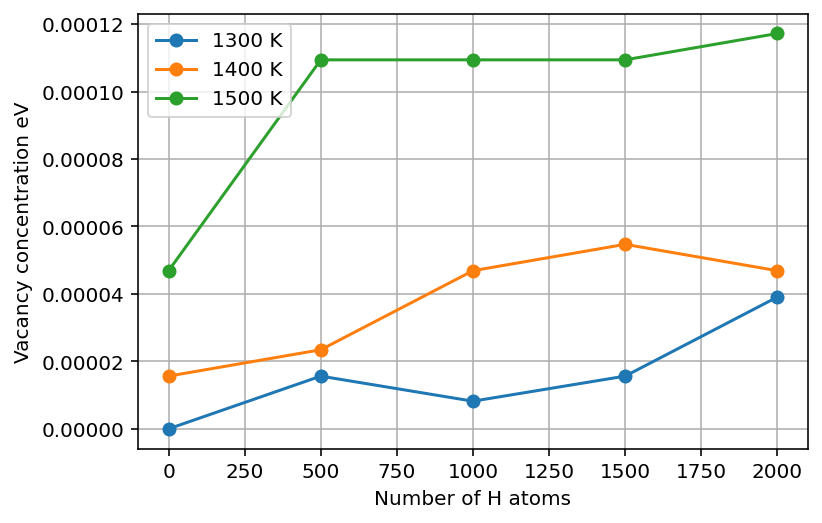

In [79]:
plt.xlabel('Number of H atoms')
plt.ylabel('Vacancy concentration eV')
plt.grid()

for t in data.input.temperature[-3:]:
    v = [v_concentration['minim_{}_{}_101'.format(n, t)] for n in data.input.n_hydrogen]
    plt.plot(data.input.n_hydrogen, v, '-o', label='{} K'.format(t))
plt.legend();

In [ ]:
len(counts)

In [ ]:
vac_dict

In [ ]:
job = pr.load('minim_1000_1500_101')
structure = job.get_structure()
cna = np.array(job['user/cna'])

In [ ]:
x = structure.positions[cna!='bcc']

In [ ]:
plt.scatter(x[:,0], x[:,2], marker='.')
plt.scatter(x[:,1], x[:,2], marker='.')

In [ ]:
cluster = AgglomerativeClustering(distance_threshold=5, n_clusters=None, linkage='single')
result = cluster.fit(x)
labels = cluster.labels_
unique, counts = np.unique(labels, return_counts=True)
x_mean = np.array([np.mean(x[labels==ii], axis=0) for ii in np.unique(labels)])
in_box = np.all(x_mean[:,:2]>0, axis=-1) & np.all(x_mean[:,:2]-structure.cell.diagonal()[:2]<0)
counts = counts[in_box]
len(counts)+np.sum(counts>15)-4

In [ ]:
counts

In [ ]:
counts

In [ ]:
unique[counts==21]

In [ ]:
x_cluster = x[labels==1]

In [ ]:
px.scatter_3d(x=x_cluster[:,0], y=x_cluster[:,1], z=x_cluster[:,2])

In [ ]:
plt.plot(x_cluster[:,0], x_)

In [ ]:
x_mean = np.array([np.mean(x[result.labels_==ii], axis=0) for ii in np.unique(result.labels_)])

In [ ]:
np.sum(np.all(x_mean[:,:2]>0, axis=-1) & np.all(x_mean[:,:2]-structure.cell.diagonal()[:2]<0, axis=-1))

In [ ]:
# plt.figure(figsize=(16,16))
plt.plot(x[:,0], x[:,2], '.')
plt.plot(x_mean[:,0], x_mean[:,2], '.')
# plt.figure(figsize=(16,16))
# plt.plot(x[:,1], x[:,2], '.')
# plt.plot(x_mean[:,1], x_mean[:,2], '.')

In [ ]:
# plt.figure(figsize=(16,16))
plt.plot(x_amorph[:,1], x_amorph[:,2], '.')
plt.plot(x_mean[:,1], x_mean[:,2], '.')

In [ ]:
# plt.figure(figsize=(16,16))
plt.plot(x[cna!='bcc',0], x[cna!='bcc',2], '.')